In [1]:
import sys
import os

notebook_path = os.getcwd() 
project_root = os.path.dirname(notebook_path)

if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
import NN_models
import Filters
import utils
import Systems
from torch.utils.data import TensorDataset, DataLoader, random_split
from state_NN_models.StateKalmanNetWithKnownR import StateKalmanNetWithKnownR

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [ ]:
h_true_nonlinear = lambda x: 0.5 * x
f_true_nonlinear = lambda x: 0.9 * x - 0.05 * x**3 

Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])

Ex0_true = torch.tensor([[1.0]])
P0_true = torch.tensor([[0.5]])

sys_true = Systems.NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

#  Nepřesná dynamika (lineární aproximace nelineární funkce f)
f_model_nonlinear = lambda x: 0.9 * x 
h_model_nonlinear = h_true_nonlinear
# Nepřesná znalost šumu (podcenění Q)
Q_model = torch.tensor([[0.01]])
R_model = torch.tensor([[0.2]])
# Nepřesný počáteční odhad (pro EKF)
Ex0_model = torch.tensor([[0.5]])
P0_model = torch.tensor([[0.5]])

# Sestavení nepřesného modelu pro filtry
# Funkce h, R jsou pro jednoduchost stejné, ale f, Q, Ex0, P0 jsou jiné
# sys_model = Systems.NonlinearSystem(f_model_nonlinear, h_model_nonlinear, Q_model, R_model, Ex0_model, P0_model)
# sys_model = Systems.NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_model, P0_model)
sys_model = Systems.NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_model, R_true, Ex0_model, P0_model)

In [6]:
TRAIN_SEQ_LEN = 10      # Krátké sekvence pro stabilní trénink (TBPTT)
VALID_SEQ_LEN = 20      # Stejná délka pro konzistentní validaci
TEST_SEQ_LEN = 200      # Dlouhé sekvence pro testování generalizace

NUM_TRAIN_TRAJ = 2000   # Hodně trénovacích příkladů
NUM_VALID_TRAJ = 500    # Dostatek pro spolehlivou validaci
NUM_TEST_TRAJ = 100     # Pro robustní vyhodnocení

BATCH_SIZE = 16         # Dobrý kompromis

x_train, y_train = utils.generate_data(sys_true, num_trajectories=NUM_TRAIN_TRAJ, seq_len=TRAIN_SEQ_LEN)
x_val, y_val = utils.generate_data(sys_true, num_trajectories=NUM_VALID_TRAJ, seq_len=VALID_SEQ_LEN)
x_test, y_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=TEST_SEQ_LEN)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
ekf = Filters.ExtendedKalmanFilter(sys_model)
y_test_seq = y_test.squeeze(0)
ekf_results = ekf.apply_filter(y_test_seq)
x_hat_ekf = ekf_results['x_filtered']
P_hat_ekf = ekf_results['P_filtered']

In [8]:
state_knet = StateKalmanNetWithKnownR(sys_model, device=device, hidden_size_multiplier=10).to(device)
utils.train_state_KalmanNet(
    model=state_knet, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=device, 
    epochs=150, 
    lr=1e-4,
    early_stopping_patience=15
)

/home/luky/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [5/150], Train Loss: 0.136596, Val Loss: 0.133605
Epoch [10/150], Train Loss: 0.134433, Val Loss: 0.132747
Epoch [15/150], Train Loss: 0.133192, Val Loss: 0.131741
Epoch [20/150], Train Loss: 0.132350, Val Loss: 0.131017
Epoch [25/150], Train Loss: 0.131810, Val Loss: 0.130462
Epoch [30/150], Train Loss: 0.131500, Val Loss: 0.130191
Epoch [35/150], Train Loss: 0.131239, Val Loss: 0.130051
Epoch [40/150], Train Loss: 0.131118, Val Loss: 0.129935
Epoch [45/150], Train Loss: 0.131007, Val Loss: 0.129824
Epoch [50/150], Train Loss: 0.130928, Val Loss: 0.129843
Epoch [55/150], Train Loss: 0.130879, Val Loss: 0.129699
Epoch [60/150], Train Loss: 0.130814, Val Loss: 0.129714
Epoch [65/150], Train Loss: 0.130778, Val Loss: 0.129695
Epoch [70/150], Train Loss: 0.130757, Val Loss: 0.129713

Early stopping spuštěno po 74 epochách.
Trénování dokončeno.
Načítám nejlepší model s validační chybou: 0.129631


StateKalmanNetWithKnownR(
  (dnn): DNN_KalmanNet(
    (input_layer): Linear(in_features=2, out_features=20, bias=True)
    (gru): GRU(20, 20)
    (output_layer): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
# Ujistěte se, že importujete i vaši EKF třídu
# from filters import ExtendedKalmanFilter # nebo jaký je váš import

# --- 1. Generování dat (beze změny) ---
TEST_SEQ_LEN = 200
NUM_TEST_TRAJ = 10

print(f"Generuji {NUM_TEST_TRAJ} testovacích trajektorií...")
# Předpokládám, že `utils.generate_data` a `sys_true` jsou definovány
x_test, y_test = utils.generate_data(sys_true, num_trajectories=NUM_TEST_TRAJ, seq_len=TEST_SEQ_LEN)

# Nastavení modelu do evaluačního módu
state_knet.eval()

# --- 2. Vyhodnocovací smyčka ---

# Seznamy pro sběr metrik z každé trajektorie
all_mse_knet, all_anees_knet = [], []
all_mse_ekf, all_anees_ekf = [], []

print(f"Vyhodnocuji na {NUM_TEST_TRAJ} testovacích trajektoriích...")

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        y_test_seq = y_test[i]
        x_true_seq = x_test[i].cpu()
        
        # --- Vyhodnocení StateKalmanNetWithKnownR (správná inicializace a ořezávání) ---
        initial_state_knet = x_true_seq[0, :].unsqueeze(0).to(device)
        state_knet.reset(batch_size=1, initial_state=initial_state_knet)
        
        knet_predictions_x, knet_predictions_P = [], []
        
        for t in range(1, TEST_SEQ_LEN):
            y_t = y_test_seq[t, :].unsqueeze(0).to(device)
            x_filtered_t, P_filtered_t = state_knet.step(y_t)
            knet_predictions_x.append(x_filtered_t.squeeze(0).cpu())
            knet_predictions_P.append(P_filtered_t.squeeze(0).cpu())
            
        x_hat_knet_run = torch.stack(knet_predictions_x, dim=0)
        P_hat_knet_run = torch.stack(knet_predictions_P, dim=0)
        
        # --- Vyhodnocení ExtendedKalmanFilter (upraveno pro apply_filter) ---
        
        # Vytvoříme novou, čistou instanci EKF
        ekf_instance = Filters.ExtendedKalmanFilter(sys_model)
        
        # ZMĚNA: Přizpůsobení počátečních podmínek EKF, aby odpovídaly KNet
        # Dáme mu skutečný počáteční stav, ale necháme ho použít P0 z jeho modelu
        ekf_instance.Ex0 = x_true_seq[0, :].unsqueeze(-1).to(ekf_instance.device)
        
        # Připravíme data pro EKF
        y_test_seq_ekf = y_test_seq.to(ekf_instance.device)
        
        # Zavoláme metodu .apply_filter
        ekf_results = ekf_instance.apply_filter(y_test_seq_ekf)
        
        # Získáme odhady a kovariance a přesuneme na CPU
        # Ořízneme výsledky, aby odpovídaly KNet (od t=1)
        x_hat_ekf_run = ekf_results['x_filtered'][1:, :].cpu()
        P_hat_ekf_run = ekf_results['P_filtered'][1:, :, :].cpu()
        
        # --- Výpočet metrik pro tento běh ---
        x_true_sliced = x_true_seq[1:, :]
        state_dim = x_true_sliced.shape[1]
        
        # MSE
        all_mse_knet.append(F.mse_loss(x_hat_knet_run, x_true_sliced).item())
        all_mse_ekf.append(F.mse_loss(x_hat_ekf_run, x_true_sliced).item())

        # ANEES
        nees_knet = torch.zeros(TEST_SEQ_LEN - 1)
        for t in range(TEST_SEQ_LEN - 1):
            error = x_true_sliced[t] - x_hat_knet_run[t]
            P_inv = torch.linalg.pinv(P_hat_knet_run[t])
            nees_knet[t] = error.unsqueeze(0) @ P_inv @ error.unsqueeze(-1)
        all_anees_knet.append(torch.nanmean(nees_knet).item())

        nees_ekf = torch.zeros(TEST_SEQ_LEN - 1)
        for t in range(TEST_SEQ_LEN - 1):
            error = x_true_sliced[t] - x_hat_ekf_run[t]
            P_inv = torch.linalg.pinv(P_hat_ekf_run[t])
            nees_ekf[t] = error.unsqueeze(0) @ P_inv @ error.unsqueeze(-1)
        all_anees_ekf.append(torch.nanmean(nees_ekf).item())


# --- Finální výpočet a výpis průměrných metrik ---
avg_mse_knet = np.mean(all_mse_knet)
avg_anees_knet = np.mean(all_anees_knet)
avg_mse_ekf = np.mean(all_mse_ekf)
avg_anees_ekf = np.mean(all_anees_ekf)

print("\n" + "="*50)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*50)
print("\n--- Průměrná MSE (přesnost) ---")
print(f"KalmanNet:    {avg_mse_knet:.4f}")
print(f"EKF:          {avg_mse_ekf:.4f}")
print("\n--- Průměrný ANEES (kredibilita/kalibrace) ---")
print(f"Očekávaná hodnota: {state_dim:.4f}")
print("---------------------------------------")
print(f"KalmanNet:    {avg_anees_knet:.4f}")
print(f"EKF:          {avg_anees_ekf:.4f}")
print("="*50)

# --- Vizuualizace posledního běhu (zůstává stejná) ---
# ...

Generuji 10 testovacích trajektorií...
Vyhodnocuji na 10 testovacích trajektoriích...

FINÁLNÍ VÝSLEDKY (průměr přes 10 běhů)

--- Průměrná MSE (přesnost) ---
KalmanNet:    0.1394
EKF:          0.2375

--- Průměrný ANEES (kredibilita/kalibrace) ---
Očekávaná hodnota: 1.0000
---------------------------------------
KalmanNet:    0.0157
EKF:          5.7355


Online simulace dokončena.

--- Výsledky online simulace ---
  Celková MSE: 0.1189
  ANEES: 0.0133 (Očekávaná hodnota: 1.0000)
  Průměrný čas na jeden krok filtrace: 0.9224 ms


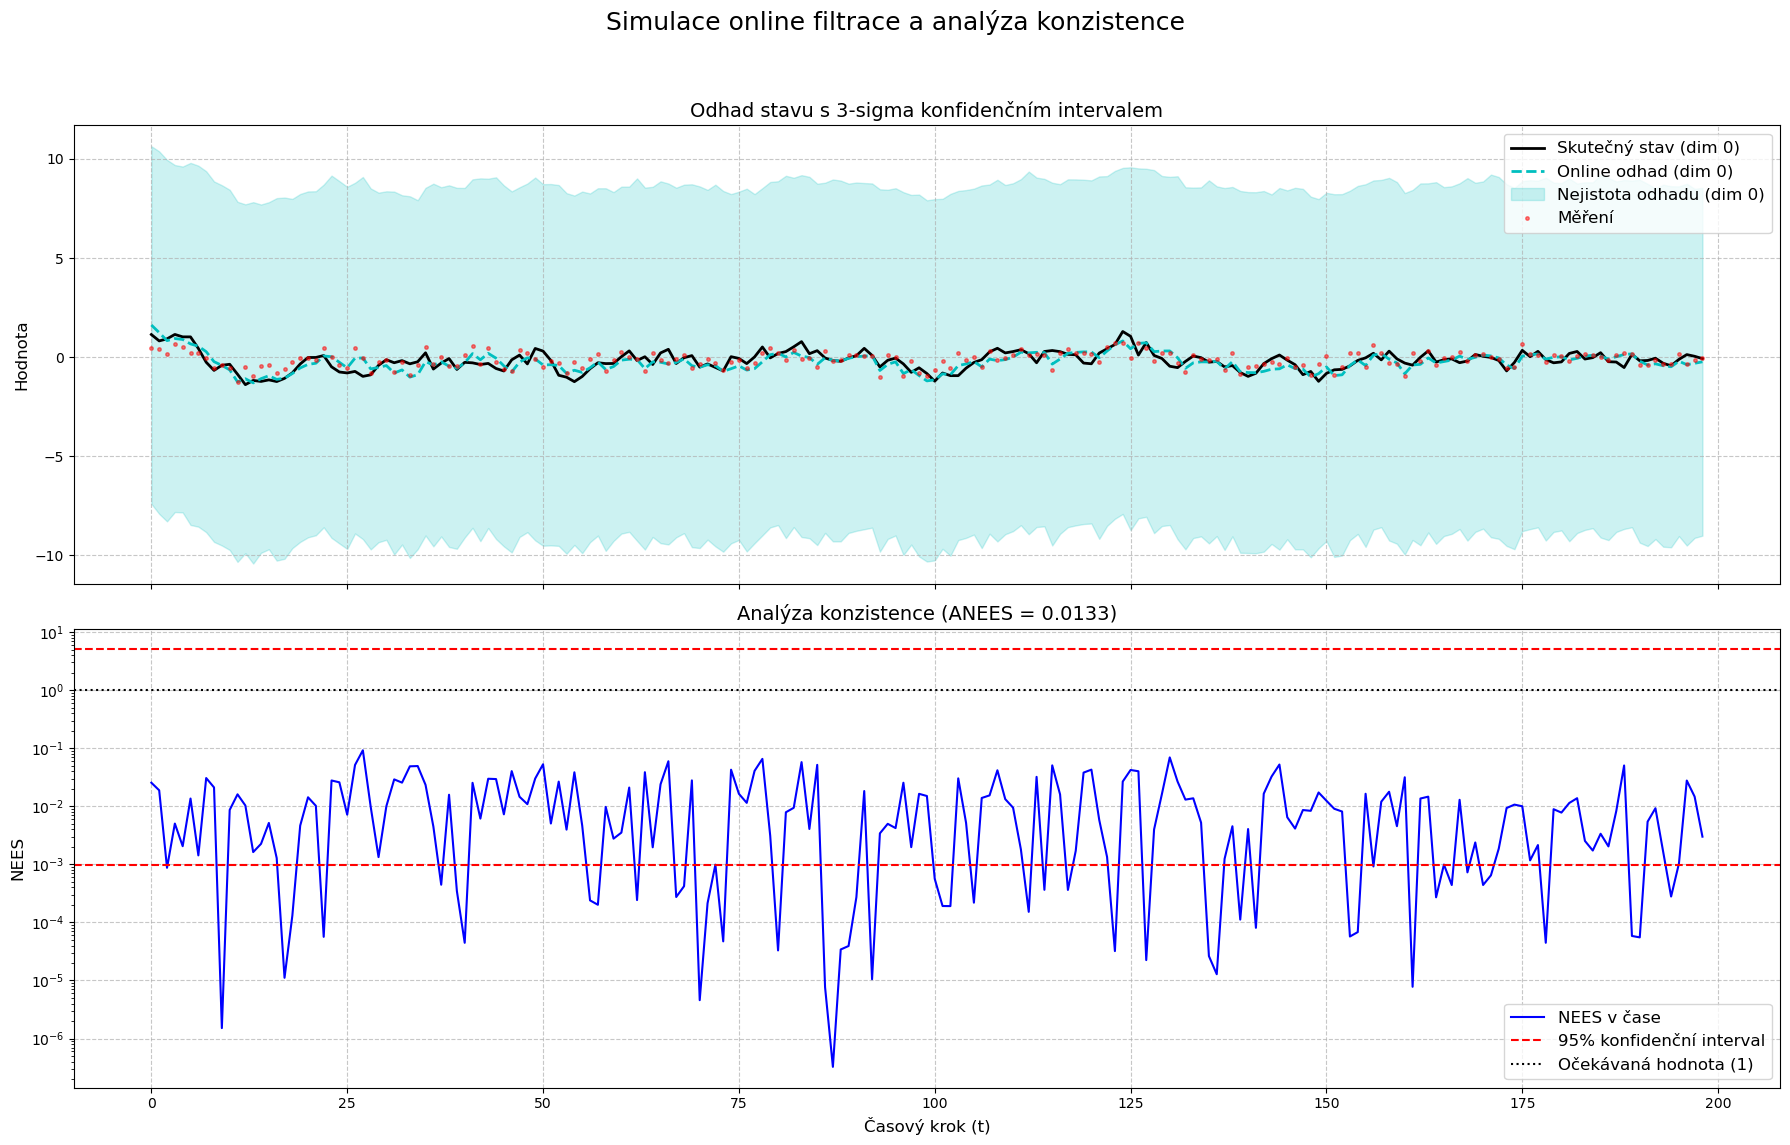

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import numpy as np
from scipy.stats import chi2

# --- 1. Generování dat (beze změny) ---
TEST_SEQ_LEN = 200
x_online_test, y_online_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=TEST_SEQ_LEN)

y_online_seq = y_online_test.squeeze(0).to(device)
x_true_seq_cpu = x_online_test.squeeze(0).cpu()

# --- 2. Simulace online filtrace (se správnou inicializací) ---
state_knet.eval()

# Správná inicializace filtru skutečným počátečním stavem
initial_state = x_true_seq_cpu[0, :].unsqueeze(0).to(device)
state_knet.reset(batch_size=1, initial_state=initial_state)

online_predictions_x = []
online_predictions_P = []
step_times = []

with torch.no_grad():
    # Smyčka začíná od t=1
    for t in range(1, TEST_SEQ_LEN):
        start_time = time.time()
        y_t = y_online_seq[t, :].unsqueeze(0)
        
        x_filtered_t, P_filtered_t = state_knet.step(y_t)
        
        end_time = time.time()
        step_times.append(end_time - start_time)
        
        online_predictions_x.append(x_filtered_t.cpu().squeeze(0))
        online_predictions_P.append(P_filtered_t.cpu().squeeze(0))

print("Online simulace dokončena.")

# Sestavení tenzorů (délka bude TEST_SEQ_LEN - 1)
x_hat_online = torch.stack(online_predictions_x, dim=0)
P_hat_online = torch.stack(online_predictions_P, dim=0)
x_true_sliced = x_true_seq_cpu[1:, :]

# --- 3. Výpočet metrik (na oříznutých datech) ---
mse_online = F.mse_loss(x_hat_online, x_true_sliced)
avg_step_time_ms = np.mean(step_times) * 1000

# Výpočet NEES a ANEES
state_dim = x_true_sliced.shape[1]
nees_samples = torch.zeros(TEST_SEQ_LEN - 1)
for t in range(TEST_SEQ_LEN - 1):
    error = x_true_sliced[t] - x_hat_online[t]
    P_t = P_hat_online[t]
    try:
        P_inv_t = torch.linalg.pinv(P_t)
        nees_samples[t] = error.unsqueeze(0) @ P_inv_t @ error.unsqueeze(-1)
    except torch.linalg.LinAlgError:
        nees_samples[t] = float('nan')

anees = torch.nanmean(nees_samples).item()

print("\n--- Výsledky online simulace ---")
print(f"  Celková MSE: {mse_online.item():.4f}")
print(f"  ANEES: {anees:.4f} (Očekávaná hodnota: {state_dim:.4f})")
print(f"  Průměrný čas na jeden krok filtrace: {avg_step_time_ms:.4f} ms")

# --- 4. Vykreslení grafů ---

# Získání směrodatné odchylky pro vizualizaci
# Vezmeme odmocninu z diagonálních prvků matice P
stdev_online = torch.sqrt(torch.diagonal(P_hat_online, dim1=-2, dim2=-1))

# Definice konfidenčního intervalu (např. 3-sigma, ~99.7%)
confidence_level = 3
upper_bound = x_hat_online + confidence_level * stdev_online
lower_bound = x_hat_online - confidence_level * stdev_online

# Vytvoření dvou subplotů
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True)
fig.suptitle("Simulace online filtrace a analýza konzistence", fontsize=18)

# --- Horní graf: Odhad stavu s nejistotou ---
ax1.set_title("Odhad stavu s 3-sigma konfidenčním intervalem", fontsize=14)
x_true_plot = x_true_sliced.numpy()
y_meas_plot = y_online_seq[1:].cpu().numpy() # Ořízneme i měření
x_hat_online_plot = x_hat_online.numpy()
upper_bound_plot = upper_bound.numpy()
lower_bound_plot = lower_bound.numpy()
time_axis = np.arange(TEST_SEQ_LEN - 1)

# Vykreslení pro každou dimenzi stavu zvlášť
colors = ['c', 'm', 'y', 'g'] # Barvy pro různé dimenze stavu
for i in range(state_dim):
    ax1.plot(time_axis, x_true_plot[:, i], 'k-', linewidth=2, label=f"Skutečný stav (dim {i})" if i==0 else None)
    ax1.plot(time_axis, x_hat_online_plot[:, i], '--', color=colors[i % len(colors)], linewidth=2, label=f"Online odhad (dim {i})")
    ax1.fill_between(time_axis, lower_bound_plot[:, i], upper_bound_plot[:, i], color=colors[i % len(colors)], alpha=0.2, label=f"Nejistota odhadu (dim {i})")

# Měření se vykreslí jen pokud má stejnou dimenzi
if y_meas_plot.shape[1] == state_dim:
    ax1.plot(time_axis, y_meas_plot, 'r.', markersize=5, alpha=0.5, label="Měření")
else:
    # Pokud jsou dimenze různé, vykreslíme jen první dimenzi měření pro ilustraci
    ax1.plot(time_axis, y_meas_plot[:, 0], 'r.', markersize=5, alpha=0.5, label="Měření (dim 0)")


ax1.set_ylabel("Hodnota", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(fontsize=12)

# --- Dolní graf: NEES a konfidenční intervaly (beze změny) ---
ax2.set_title(f"Analýza konzistence (ANEES = {anees:.4f})", fontsize=14)
nees_plot = nees_samples.numpy()
conf_interval_lower = chi2.ppf(0.025, df=state_dim)
conf_interval_upper = chi2.ppf(0.975, df=state_dim)

ax2.plot(time_axis, nees_plot, 'b-', label="NEES v čase")
ax2.axhline(y=conf_interval_lower, color='r', linestyle='--', label=f"95% konfidenční interval")
ax2.axhline(y=conf_interval_upper, color='r', linestyle='--')
ax2.axhline(y=state_dim, color='k', linestyle=':', label=f"Očekávaná hodnota ({state_dim})")

ax2.set_xlabel("Časový krok (t)", fontsize=12)
ax2.set_ylabel("NEES", fontsize=12)
ax2.set_yscale('log')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()